In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet
from tyssue import config

from tyssue.core.generation import create_anchors

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel
from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.core.objects import get_opposite

from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.plt_draw import sheet_view
import tyssue.draw.plt_draw as draw
from tyssue.stores import load_datasets
from tyssue.io import hdf5


In [2]:
import os
home = os.environ['HOME']
sim_save_dir = os.path.join(home, 'Projets/Tyssue/Simulations')
print(os.path.isdir(sim_save_dir))

True


In [3]:
min_settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-8,
            'gtol': 1e-8},
        }
    }


def load_before_apopto(anchor_tension=0, fixed_boundaries=False):

    h5store = 'before_apoptosis.hf5'
    #h5store = 'small_hexagonal.hf5'

    datasets = load_datasets(h5store,
                             data_names=['face', 'vert', 'edge'])
    specs = config.geometry.cylindrical_sheet()
    sheet = Sheet('fold', datasets, specs)
    sheet.sanitize()
    geom.update_all(sheet)

    sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)

    sheet.vert_df.is_active = 1
    if anchor_tension > 0:
        create_anchors(sheet)
        nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
        nondim_specs['edge']['anchor_tension'] = anchor_tension
    else:
        nondim_specs = config.dynamics.quasistatic_sheet_spec()
        if fixed_boundaries:
            free_edges = sheet.edge_df[sheet.edge_df.opposite==-1].index
            free_srces = set(sheet.edge_df.loc[free_edges, 'srce'])
            sheet.vert_df.loc[free_srces, 'is_active'] = 0
            #free_faces = set(sheet.edge_df.loc[free_edges, 'face'])
            #sheet.face_df.loc[free_faces, 'is_alive'] = 0

    dim_model_specs = model.dimentionalize(nondim_specs)
    sheet.update_specs(dim_model_specs, reset=True)
    isotropic_relax(sheet, nondim_specs)
    # sheet.vert_df.loc[dead_src, 'is_active'] = 0
    return sheet, nondim_specs

sheet, nondim_specs = load_before_apopto(0, fixed_boundaries=True)
geom.update_all(sheet)

In [4]:
canvas, view = vp_view(sheet, coords=['z', 'x', 'y'])

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


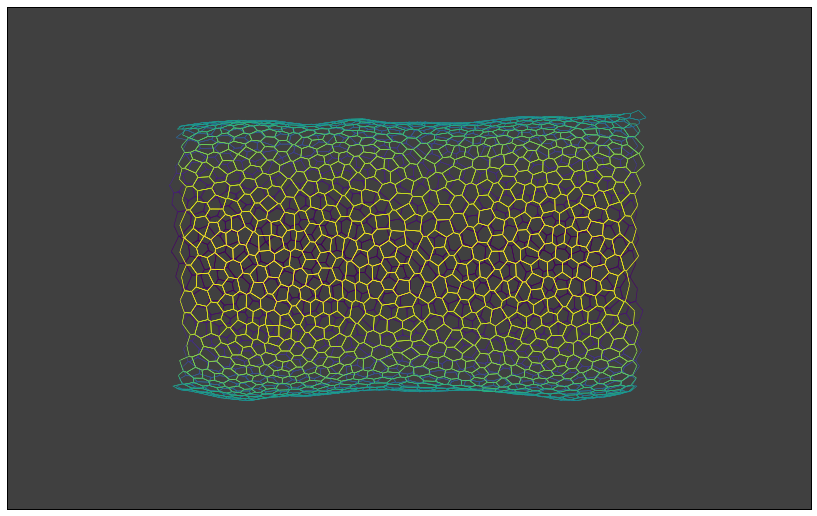

In [5]:
def leg_joint_view(sheet, coords=['z', 'x', 'y']):

    x, y, z = coords
    datasets = {}
    
    datasets['face'] = sheet.face_df.sort_values(z)
    datasets['vert'] = sheet.vert_df.sort_values(z)
    edge_z = 0.5 * (sheet.upcast_srce(sheet.vert_df[z]) +
                    sheet.upcast_trgt(sheet.vert_df[z]))
    datasets['edge'] = sheet.edge_df.copy()
    datasets['edge'][z] = edge_z
    datasets['edge'] = datasets['edge'].sort_values(z)
    
    tmp_sheet = Sheet('tmp', datasets,
                      sheet.specs)
    tmp_sheet.reset_index()
    cmap = plt.cm.get_cmap('viridis')
    
    e_depth = (tmp_sheet.edge_df[z] -
               tmp_sheet.edge_df[z].min()) / tmp_sheet.edge_df[z].ptp()
    depth_cmap = cmap(e_depth)
    draw_specs = {
        'vert': {
            'visible': False
            },
        'edge': {
            'color': depth_cmap,
            #'zorder': depth.values
            }
        }
    
    fig, ax = sheet_view(tmp_sheet, coords[:2], **draw_specs)
    ax.set_xlim(-80, 80)
    ax.set_ylim(-50, 50)
    ax.set_axis_bgcolor('#404040')
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.set_frame_on(False)
    fig.set_size_inches((16, 9))
    fig.set_frameon(False)
    fig.set_clip_box(ax.bbox)
    return fig, ax

fig, ax = leg_joint_view(sheet)
plt.savefig('before.png', bbox_inches='tight')

In [6]:
res = solver.find_energy_min(sheet, geom, model, **min_settings)
print(res['success'])

True


number of apoptotic cells: 31


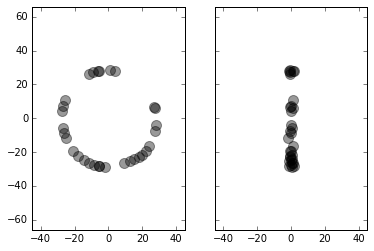

In [12]:
def apopto_pdf(zed, theta, z0=0.,
               width_apopto=1.1, amp=0.7):
    p = (np.exp(-(zed - z0)**2 / width_apopto**2) *
         (1 - amp*(np.cos(theta/2)**2)))
    return p

def get_apopto_cells(sheet):

    np.random.seed(40)
    sheet.face_df['theta'] = np.arctan2(sheet.face_df['x'],
                                        sheet.face_df['y'])
    
    p_apopto = apopto_pdf(sheet.face_df['z'], sheet.face_df['theta'])
    rand_field = np.random.random(sheet.face_df.shape[0])
    apopto_cells = p_apopto[p_apopto>rand_field].index
    apopto_cells = np.array([c for c in sheet.face_df.loc[apopto_cells].sort_values('x').index
                             if sheet.face_df.loc[c, 'is_alive']])
    return apopto_cells

apopto_cells = get_apopto_cells(sheet)
print('number of apoptotic cells: {}'.format(apopto_cells.size))

fig, (ax0, ax1) = plt.subplots(1, 2, sharex=True, sharey=True)
ax0.scatter(sheet.face_df.loc[apopto_cells, 'x'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax0.set_aspect('equal')


ax1.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
            sheet.face_df.loc[apopto_cells, 'y'], c='k',
            s=100, alpha=0.4)
ax1.set_aspect('equal')
ax1.set_xlim(-45, 45);

In [13]:
apopto_cells

array([ 416,  470, 1491, 1653,  389, 1661, 1629,  551, 1378,  281,  605,
       1316, 1371,  254, 1607,  255,  632, 1527,  986,  200,  918,  713,
        940,  740, 1464, 1027,  767, 1197,   40, 1537,  848])

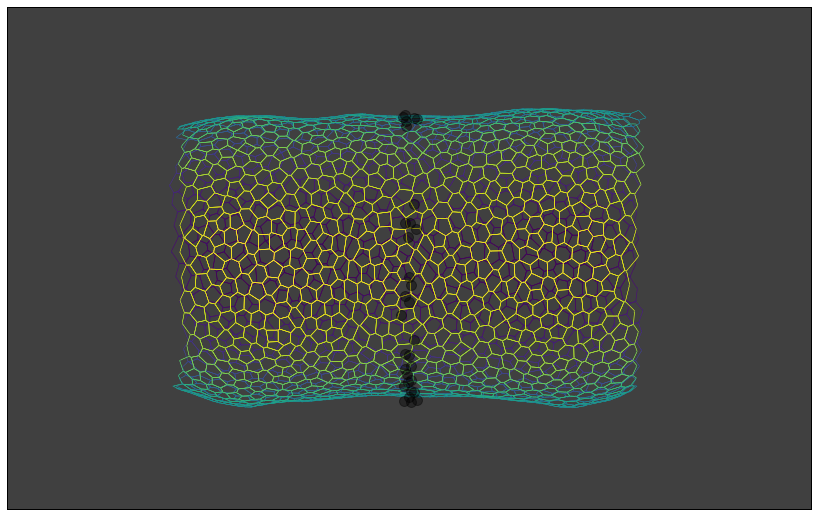

In [14]:
fig, ax = leg_joint_view(sheet)

ax.scatter(sheet.face_df.loc[apopto_cells, 'z'], 
           sheet.face_df.loc[apopto_cells, 'y'], c='k',
           s=100, alpha=0.4)

plt.savefig('before.png', bbox_inches='tight')

In [15]:
sheet.specs

{'edge': {'dx': 0.0,
  'dy': 0.0,
  'dz': 0.0,
  'face': 0,
  'length': 0.0,
  'line_tension': 2873.2644436598594,
  'nx': 0.0,
  'ny': 0.0,
  'nz': 1.0,
  'srce': 0,
  'trgt': 0},
 'face': {'area': 1.0,
  'contractility': 276.48,
  'is_alive': True,
  'num_sides': 6,
  'perimeter': 1.0,
  'prefered_area': 12.0,
  'prefered_height': 24.0,
  'prefered_vol': 288.0,
  'vol_elasticity': 1.0,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0},
 'settings': {'geometry': 'cylindrical',
  'grad_norm_factor': 23943.87036383216,
  'height_axis': 'z',
  'nrj_norm_factor': 82944.0},
 'vert': {'basal_shift': 4.0,
  'height': 0.0,
  'is_active': True,
  'radial_tension': 0.0,
  'rho': 0.0,
  'x': 0.0,
  'y': 0.0,
  'z': 0.0}}

In [17]:
from tyssue.behaviors.sheet_events import SheetEvents
from tyssue.behaviors.behaviors import apoptosis_time_table
from tyssue.topology.sheet_topology import remove_face
import os

import logging
logger = logging.Logger('event_log')

def get_time_table(sheet, apopto_cells,
                   events):

    time_tables = []
    for strat_t, cell in enumerate(apopto_cells):

        times, time_table = apoptosis_time_table(sheet, cell,
                                                 events, start_t=strat_t)
        time_tables.append(time_table)
    time_table = pd.concat(time_tables).sort_index()
    times = time_table.index.levels[0]
    return times, time_table

def local_active(sheet, face):
    
    f_verts = sheet.edge_df[sheet.edge_df['face'] == face]['srce']
    sheet.vert_df.is_active = 0
    sheet.vert_df.is_active.loc[f_verts] = 1
    

def time_step(face_events, events,
              sheet, geom, model, dirname):
    buf_active = sheet.vert_df['is_active'].copy()
    for face, evts in face_events.iterrows():
        if np.isnan(face): # don't know why this happens
            continue
        for event_name, event_arg in evts.dropna().items():
            if ((not sheet.face_df.loc[face, 'is_alive']) or
                np.isnan(sheet.face_df.loc[face, 'is_alive'])):
                logger.info('skipped: face: {}, event: {}'.format(face, event_name))
                continue
            events[event_name](face, event_arg)
            try:
                #pos_idx = sheet.edge_df[sheet.edge_df['face'] == face]['srce']
                #res = solver.find_energy_min(sheet, geom, model,
                #                             pos_idx=pos_idx, **settings)
                logger.info('done: face: {}, event: {}'.format(face, event_name))
            except:
                continue
    #pos_idx = sheet.vert_df[(sheet.vert_df.z > -3)  & (sheet.vert_df.z < 3)].index

    # relax the rest
    res = solver.find_energy_min(sheet, geom, model, **min_settings)

    
def run_sim(sheet, apopto_cells,
            geom, model, dirname):
    
    times, time_table = get_time_table(sheet, apopto_cells,
                                       events)
    event_logfile = os.path.join(dirname, 'events.log')
    hdlr = logging.FileHandler(event_logfile)
    hdlr.setLevel('INFO')
    logger.addHandler(hdlr)
    
    for t in times:
        face_events = time_table.loc[t]
        time_step(face_events, events,
                  sheet, geom, model, dirname)
        fig, ax = leg_joint_view(sheet)
        if t // 10 == 0:
            # relax boundary cells
            sheet.vert_df.is_active = 1 - sheet.vert_df.is_active
            res = solver.find_energy_min(sheet, geom, model, **min_settings)
            sheet.vert_df.is_active = 1 - sheet.vert_df.is_active

        
        figname = os.path.join(
            dirname, 'fold_formation_{:03d}.png'.format(t))
        plt.savefig(figname, bbox_inches='tight')
        plt.close(fig)
        
        
        
    logger.removeHandler(hdlr)


In [ ]:
settings = {
    'shrink_steps': 10,
    'rad_tension': 2.0,
    'contractile_increase': 2.0,
    'contract_span': 3
    }

tensions = [1,]# 1]#, 0, 0]
contracts = [2,]# 0]#, 2, 0]
dirnames = ['{}_lambda_{}_gamma'.format(l, g)
            for l, g in zip(tensions, contracts)]
dirnames = [os.path.join(sim_save_dir, dirname)
            for dirname in dirnames]

for l, g, dirname in zip(tensions, contracts, dirnames):
    
    datasets = {key: val.copy() for key, val
                in sheet.datasets.items()}
    specs = sheet.specs
    
    sheet2 = Sheet('fold', datasets, specs) # load_before_apopto()
    events = SheetEvents(sheet2, model, geom).events
    res = solver.find_energy_min(sheet2, geom, model,
                                 **min_settings)
    print('starting {}'.format(dirname))
    try:
        os.mkdir(dirname)
    except IOError:
        pass
    settings.update(
        {'rad_tension': l,
         'contractile_increase': g})
    sheet2.settings['apoptosis'] = settings
    run_sim(sheet2, apopto_cells,
            geom, model, dirname)

    print('{} done'.format(dirname))
    print('~~~~~~~~~~~~~~~~~~~~~\n')
    

starting /home/guillaume/Projets/Tyssue/Simulations/1_lambda_2_gamma


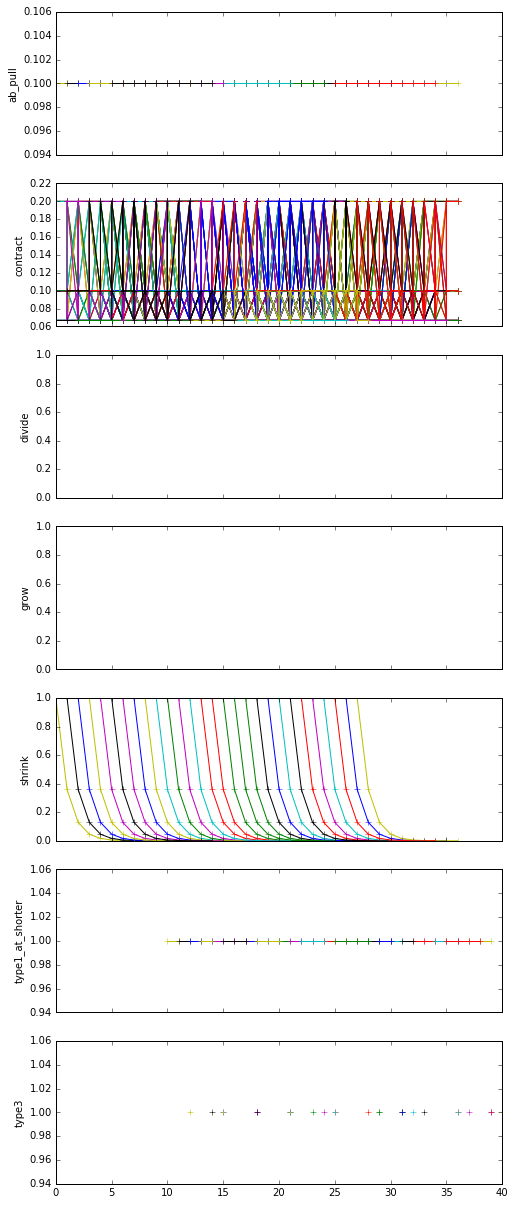

In [15]:
times, time_table = get_time_table(sheet, apopto_cells,
                                   events)

n_events = len(time_table.columns)
fig, axes = plt.subplots(n_events, 1, sharex=True)

fig.set_size_inches(8, 3*n_events)

for f, face_data in time_table.groupby(level='face'):
    for ax, col in zip(axes, time_table.columns):
        col_data = face_data[col].dropna()
        if col_data.shape[0]:
            ax.plot(col_data.index.get_level_values(0).values,
                    col_data.values, '+-', label=str(f))

for ax, col in zip(axes, time_table.columns):
    ax.set_ylabel(col)

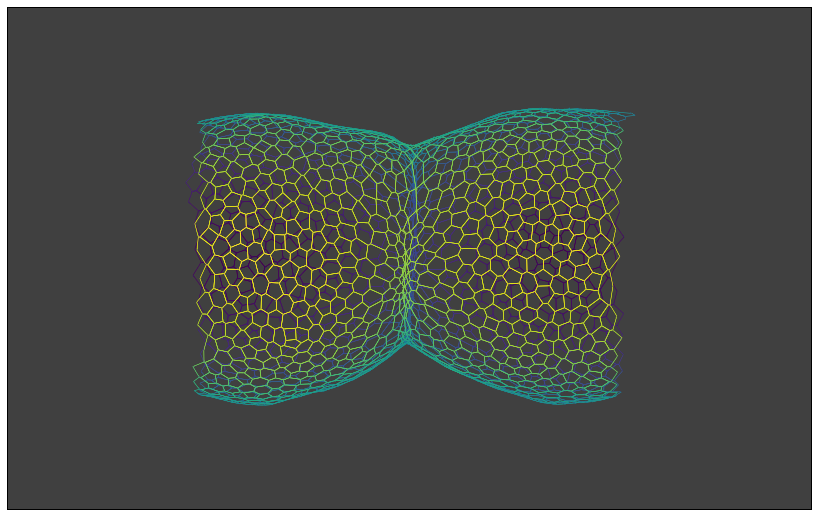

In [19]:
fig, ax = leg_joint_view(sheet2)